### 240 Project: Clouds Patterns Detection

In [1]:
import os
import io
import math
import gc
import cv2
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing:

In [2]:
path = '../input/understanding_cloud_organization'
os.listdir(path)

['test_images', 'train.csv', 'train_images', 'sample_submission.csv']

In [33]:
train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/sample_submission.csv')

In [34]:
train_new = pd.DataFrame()
train_new['img'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train_new['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train_new['EncodedPixels'] = train['EncodedPixels']
test_new = pd.DataFrame()
test_new['img'] = test['Image_Label'].apply(lambda x: x.split('_')[0])
test_new['label'] = test['Image_Label'].apply(lambda x: x.split('_')[1])
test_new['EncodedPixels'] = test['EncodedPixels']

In [35]:
train_new.head(n=8)

,img,label,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg,Gravel,NaN
3,0011165.jpg,Sugar,NaN
4,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg,Flower,1339279 519 1340679 519 1342079 519 1343479 51...
6,002be4f.jpg,Gravel,NaN
7,002be4f.jpg,Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...


In [36]:
test_new.head(n=8)

,img,label,EncodedPixels
0,002f507.jpg,Fish,1 1
1,002f507.jpg,Flower,1 1
2,002f507.jpg,Gravel,1 1
3,002f507.jpg,Sugar,1 1
4,0035ae9.jpg,Fish,1 1
5,0035ae9.jpg,Flower,1 1
6,0035ae9.jpg,Gravel,1 1
7,0035ae9.jpg,Sugar,1 1


In [6]:
n_train = len(os.listdir(f'{path}/train_images'))
n_test = len(os.listdir(f'{path}/test_images'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


### Data distibution:

In [7]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: Image_Label, dtype: int64

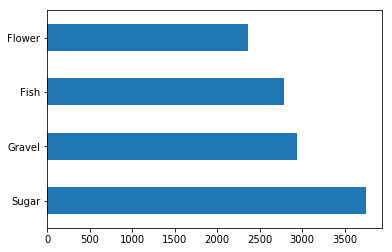

In [8]:
pd.value_counts(train_new[['label','EncodedPixels']].dropna()['label']).plot('barh');

In [9]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64

Distribution, how many figures we can find on one photo:

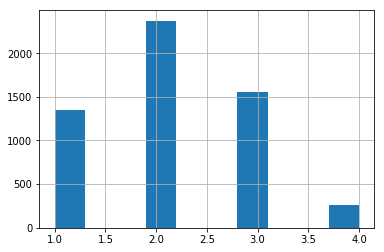

In [10]:
train_new.dropna()[['img','label']].groupby(['img']).count().reset_index()['label'].hist();

### Visualize detection area and photos:

In [11]:
def detect(train_new, img):
    image = plt.imread(f"{path}/train_images/" + img)
    rle_string = train_new[(train_new['img']==img)]['EncodedPixels'].iloc[0]
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1,2)  # reshape to nx2
    img = np.zeros(1400*2100, dtype=np.uint8)
    for index, length in rle_pairs:
        index -= 1
        img[index:index+length] = 100
    img = img.reshape(2100,1400) 
    np_mask = img.T
    np_mask = np.clip(np_mask, 0, 1)
    return np_mask

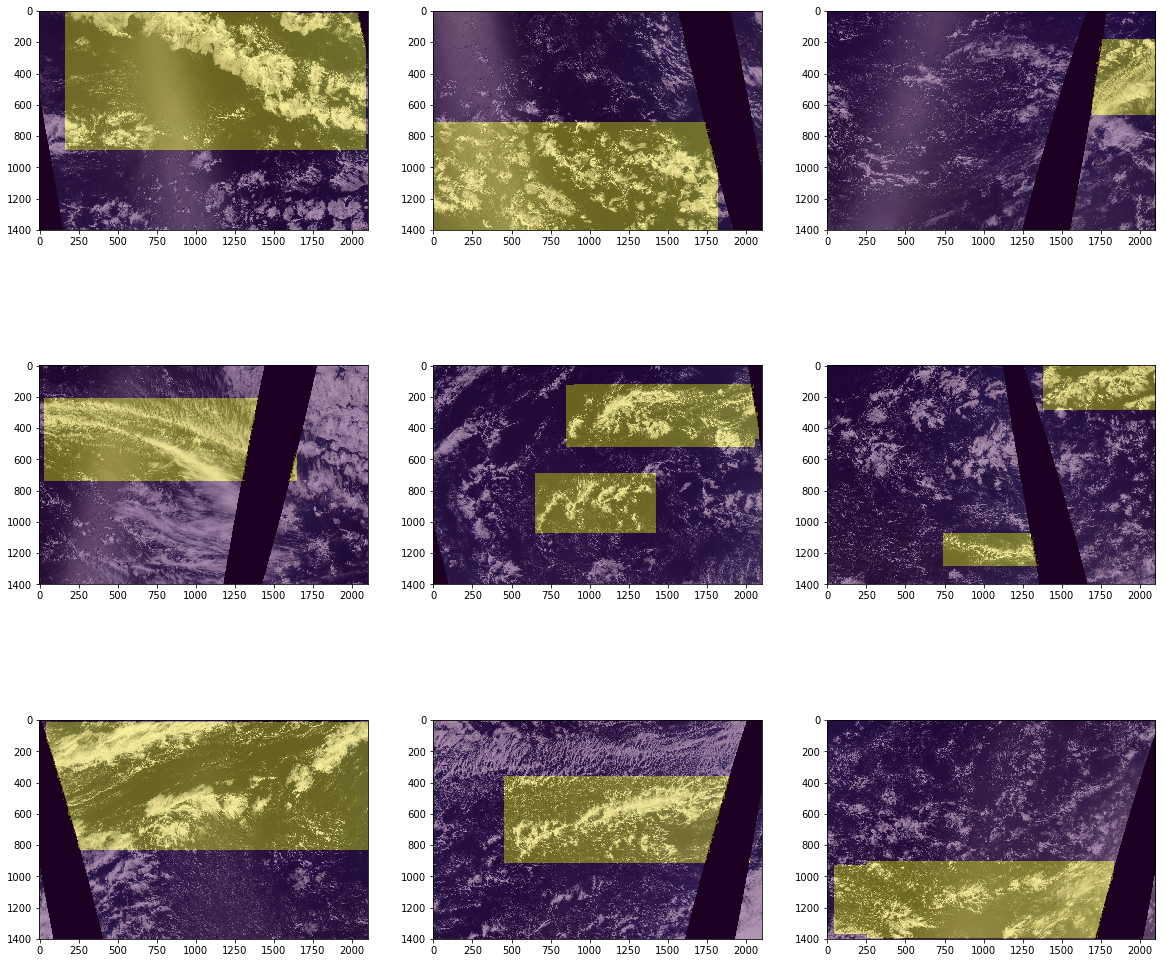

In [12]:
fig = plt.figure(figsize=(20,25))
data_vis = train_new[train_new['label']=='Fish'].dropna()
for i in range(1,10):
    fig.add_subplot(4,3,i)
    mask = detect(data_vis , data_vis.iloc[i]['img'])
    image = plt.imread(f"{path}/train_images/" + data_vis.iloc[i]['img'])
    plt.imshow(image);
    plt.imshow(mask, alpha=0.4);

### Mask Representation 
1. Label 0 or 1
2. X coordinate of detection mask center 
3. Y coordinate of detection mask center
4. Height of mask
5. Width of mask

In [13]:
# Create function that return height, width, x_center and y_center
def center_grad(label, np_mask):
    """This function return h, w, x_c, y_c of our mask"""
    height = np.where(np_mask[:,:]==1)[0][-1]-np.where(np_mask[:,:]==1)[0][0]
    width = np.where(np_mask[:,:]==1)[1][-1]-np.where(np_mask[:,:]==1)[1][0]
    x_cen, y_cen = np.where(np_mask[:,:]==1)[0][0] + height//2, np.where(np_mask[:,:]==1)[1][0] + width//2
    return label, x_cen, y_cen, height, width

### Create special Fish,Flower,Gravel,Sugar groups for our network

In [14]:
#Create special 'Fish' dataset 
fish_data = train_new[train_new['label']=='Fish']
fish_data.set_index(np.arange(fish_data.shape[0]), inplace=True)
fish_data['Label'] = fish_data['EncodedPixels'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [15]:
#Create special 'Flower' dataset 
flower_data = train_new[train_new['label']=='Flower']
flower_data.set_index(np.arange(flower_data.shape[0]), inplace=True)
flower_data['Label'] = flower_data['EncodedPixels'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [16]:
#Create special 'Gravel' dataset 
gravel_data = train_new[train_new['label']=='Gravel']
gravel_data.set_index(np.arange(gravel_data.shape[0]), inplace=True)
gravel_data['Label'] = gravel_data['EncodedPixels'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [17]:
#Create special 'Sugar' dataset 
sugar_data = train_new[train_new['label']=='Sugar']
sugar_data.set_index(np.arange(sugar_data.shape[0]), inplace=True)
sugar_data['Label'] = sugar_data['EncodedPixels'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [18]:
fish_data.head(n=8)

,img,label,EncodedPixels,Label
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...,1
1,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...,1
2,0031ae9.jpg,Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...,1
3,0035239.jpg,Fish,NaN,0
4,003994e.jpg,Fish,2367966 18 2367985 2 2367993 8 2368002 62 2369...,1
5,00498ec.jpg,Fish,NaN,0
6,006bf7c.jpg,Fish,43614 529 45014 529 46414 529 47814 529 49214 ...,1
7,006c5a6.jpg,Fish,916291 381 917691 381 919091 381 920491 381 92...,1


In [19]:
flower_data.head(n=4)

,img,label,EncodedPixels,Label
0,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,1
1,002be4f.jpg,Flower,1339279 519 1340679 519 1342079 519 1343479 51...,1
2,0031ae9.jpg,Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...,1
3,0035239.jpg,Flower,100812 462 102212 462 103612 462 105012 462 10...,1


In [20]:
height, width = 1400, 2100
def masks(train_new, name_image):
    rle_string = train_new[train_new['img']==name_image]['EncodedPixels'].values[0]
    if pd.isnull(rle_string):
        return pd.DataFrame([])
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(height*width, dtype=np.uint8) #Return a new 1400*2100 filled with zeros.
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 100
        img = img.reshape(height,width)
        img = img.T

        np_mask = img
        np_mask = np.clip(np_mask, 0, 1)
        return np_mask

### Create DataLoader for this problem:

In [21]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = train_new, datatype: str = 'train', img_ids: np.array = None,
                 transforms = transforms.ToTensor(),
#                 transforms = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.df['img'][idx]
        mask = masks(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        
        image = Image.open(image_path)
        image = self.transforms(image)
        
        if mask.shape != (0,0):
            label = center_grad(self.df.iloc[idx]['Label'],mask)
            if label[0] == 1:
                label = (label[0], label[1]/height, label[2]/width,
                            math.log(abs(label[3]+0.0001)), math.log(abs(label[4]+0.0001)) )
        else: 
            label = (0,0,0,0,0)
        return image, label
    
    def __len__(self):
        return self.df.shape[0]

### Classes distribution in "Fish dataset"

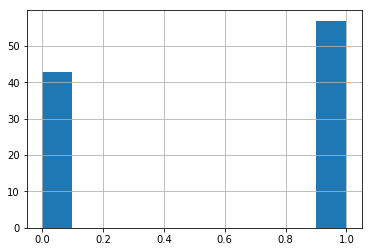

In [22]:
fish_data[:100]['Label'].hist();

In [39]:
#Helper Function
def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2.0 * intersection.sum() / (img1.sum() + img2.sum())

def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

In [40]:
train_dataset = CloudDataset(df=fish_data[:2000], datatype='train')
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, num_workers=0)
#test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=0)

In [41]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15*10*3,5)  #（15*10*3）
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=5, padding=2)
        
    def forward(self,x):
        batch =x.size(0)   #one batch
        x = F.relu(F.max_pool2d(self.conv1(x), 7))
        x = F.relu(F.max_pool2d(self.conv2(x), 5))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(batch, -1)
        x = self.fc1(x)
        #x = [F.sigmoid(x[0]),F.sigmoid(x[1]),F.sigmoid(x[2]),F.sigmoid(x[3]), F.sigmoid(x[4])]
        x = [F.sigmoid(x[0]),F.sigmoid(x[1]),F.sigmoid(x[2]),x[3], x[4]]
        return x

### Create the main function for learning with pytorch. I'll learn only 10 epochs to save time.

In [47]:
losses = []

# define model
model = Net()
model = model.cuda()
crit_mse = nn.MSELoss()
crit_bce = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)

for epoch in range(1, 2):
    print('epoch = ', epoch)
    start_time = time.time()
    for batch_idx, (data, label) in enumerate(train_loader):
            # get output        
            data = data.cuda()
            for i in range(len(label)):
                label[i] = label[i].cuda()
            output = model(data)
            
            #print(label)
            #print(output)
            
            for o0, o1, o2, o3, o4, l0, l1, l2, l3, l4 in zip(*output, *label):
                if l0 == 1:            
                    loss = crit_bce(o0,l0.float().cuda()) + \
                        1*(crit_bce(o1,l1.float().cuda()) + \
                           crit_bce(o2,l2.float().cuda()) + \
                           crit_mse(o3,l3.float().cuda()) + \
                           crit_mse(o4,l4.float().cuda() ) )
                else:
                    loss = crit_bce(o0,l0.float().cuda())
                    
            """
            #for o0, o1, o2, o3, o4, l0, l1, l2, l3, l4 in zip(*output, *label):
            if l0 == 1:            
                loss = crit_bce(o0,l0.float().cuda()) + \
                    1*(crit_bce(o1,l1.float().cuda()) + \
                       crit_bce(o2,l2.float().cuda()) + \
                       crit_mse(o3,l3.float().cuda()) + \
                       crit_mse(o4,l4.float().cuda()) )
            else:
                loss = crit_bce(o0,l0.float().cuda())
            """
       
            #else:
                #loss = crit_bce(output[0],torch.Tensor([label[0]]).cuda() )
            # define complex LOSS function
            """
            if label[0].item() == 1:            
                loss = crit_bce(output[0],torch.Tensor([label[0].item()]).cuda() ) + \
                     1*(crit_bce(output[1],torch.Tensor([label[1].item()]).cuda() ) +  
                       crit_bce(output[2],torch.Tensor([label[2].item()]).cuda() ) + \
                       crit_mse(output[3],torch.Tensor([label[3].item()]).cuda() ) + \
                       crit_mse(output[4],torch.Tensor([label[4].item()]).cuda() ) )
       
            else:
                loss = crit_bce(output[0],torch.Tensor([label[0].item()]).cuda() )
            """          
            if batch_idx % 500 == 0:
                print('Loss :{:.4f} Epoch - {}/{}'.format(loss.item(), epoch, 10))
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
    
    torch.cuda.empty_cache()
    gc.collect()
    print("--- %s seconds ---" % (time.time() - start_time))
    del data, label
    
    

epoch =  1
Loss :89.0565 Epoch - 1/10


KeyboardInterrupt: 

### Loss illustration for train dataset:

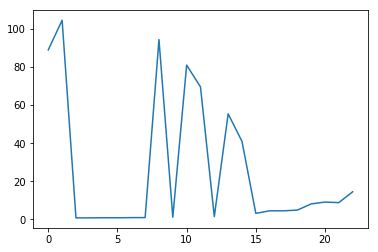

In [48]:
plt.plot(np.arange(len(losses)), losses);

In [53]:
dice_list =[]
with torch.no_grad():
        model.eval()
        for batch_idx, (data, label) in enumerate(train_loader):
            data = data.cuda()
            for i in range(len(label)):
                label[i] = label[i].cuda()
            output = model(data)
            dice_cof = dice_no_threshold(output.cpu(), label.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            
dice_score = dice_score/len(train_loader.dataset)
dice_list.append(dice_score)
print('Epoch: {} Dice Score: {:.6f}'.format(epoch, dice_score))

AttributeError: 'list' object has no attribute 'cpu'

### Compare model prediction with target mask:

In [54]:
#Helper function of Dice coefficient
def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

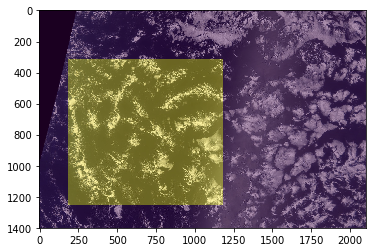

In [55]:
mask = detect(data_vis , data_vis.iloc[0]['img'])
image = plt.imread(f"{path}/train_images/" + data_vis.iloc[0]['img'])
plt.imshow(image);
plt.imshow(mask, alpha=0.4);

In [57]:
ss = center_grad(1, mask)
print(ss[0], ss[1]/height, ss[2]/width, math.log(ss[3]), math.log(ss[4]))
print(ss[0], ss[1], ss[2], ss[3], ss[4])
print(dice(image, ss))

1 0.5607142857142857 0.32666666666666666 6.841615476477592 6.901737206656574
1 785 686 936 994


ValueError: operands could not be broadcast together with shapes (1400,2100,3) (5,) 

In [ ]:
img = torch.Tensor(image.reshape(1,3,1400,2100)).cuda()
model(img)

With same approach we can detect another categories. 

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
#sub = pd.read_csv(f'{path}/sample_submission.csv')
#test_dataset = CloudDataset(df=sub, datatype='test', img_ids=test_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
test_dataset = CloudDataset(df=sub, datatype='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

loaders = {"test": test_loader}